# Project
<font size="3">
    
- Project session 에서는 Tutorial 에서 다루었던 masking 된 베어링 데이터셋에 대해서 실습을 이어나갑니다.

- 마스킹 이후에 떨어진 Simple model의 accuracy를 개선할 수 있는 모델 아키텍쳐를 제안하고 학습하며, 평가하는 과정을 경험해보는 것이 이 프로젝트의 목표 입니다. 

- 모델의 성능을 올리기 위해 개선할 수 있는 요소는 다음과 같습니다.

</font>
<font size="2">
   
        1. semi-supervised learning 의 적용
        : unlabeled data 는 labeled data에 비해 많기 때문에, 이를 활용하여 효율적인 학습을 할 수 있습니다. 강의에서 다루었던 pseudo-labeling, entropy minimization 그리고 consistency regularization을 적용해볼 수 있으며, 이에 대한 자세한 설명과 Sample code는 'sample_notebooks/SampleSemiSupervised.ipynb' 를 참조해볼 수 있습니다.
    
        2. Encoder의 구조 변형
        : Encoder의 구조 변형을 통해, 모델의 Feature Extraction 파트를 개선해 볼 수 있습니다. Convolution layer를 확장한 DilatedCNN, 각 layer의 output을 쌓아 최종 output을 만드는 방법 그리고 variational model 을 사용하는 것 등이 있습니다. 이에 관한 설명 및 Sample code는 "sample_notebooks/SampleEncoder.ipynb' 에 첨부되어 있습니다.

        3. 이외에도 모델의 성능을 올릴 수 있는 어떠한 방법이든 적용하여 모델을 구축할 수 있습니다.
</font>        

<font size="3">
Tutorial의 Sample model과 앞서 언급한 Sample code들을 참조하여, label data가 부족한 상황에서 만들 수 있는 최적의 모델을 만듭니다.
</font>

In [1]:
# enable auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os

## 1. Preprocessed Data 로드

In [3]:
RAW_PATH = './data'            # path to raw data
NP_PATH = './preprocessed'     # path to preprocessed data
FRAME_LEN = 1024               # length of one data frame
FRAME_INTV = 512               # interval between data frames

if not os.path.exists(NP_PATH):
    os.mkdir(NP_PATH)

In [4]:
from src.utils.data_utils import get_preprocessed_data

## load preprocessed data
DATA, train_idx, test_idx, trainY, testY, train_diameter, test_diameter, train_rpm, test_rpm = get_preprocessed_data(RAW_PATH, NP_PATH, FRAME_LEN, FRAME_INTV)

print('DATA :\t\t', DATA.shape)
print('train_idx :\t', train_idx.shape)
print('test_idx :\t', test_idx.shape)
print('trainY :\t', trainY.shape)
print('testY :\t\t', testY.shape)
print('train_diameter :', train_diameter.shape)
print('test_diameter :\t', test_diameter.shape)
print('train_rpm :\t', train_rpm.shape)
print('test_rpm :\t', test_rpm.shape)

## 2. Semisupervised Learning!!!!

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
## fix seeds for reproducibility
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True

## benchmark mode
torch.backends.cudnn.benchmark=True

In [7]:
SAVE_PATH = './saved_models'      ## path to save model weights
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


Tutorial 4.1설명 그대로 가져오기! -> 정리!

In [8]:
MASK_P = 0.005        ## Only (100*MASK_P)% of train data are labeled
SCREEN_DIAM = 2       ## all data with diameter SCREEN_DIAM are fixed unlabeled

MASK_PARAMS = {
    'mask_p' : MASK_P,
    'screen_diam' : SCREEN_DIAM,
    'trainY' : trainY,
    'train_diameter' : train_diameter
}

In [9]:
from src.utils.data_utils import get_shuffle_n_mask

train_shuffle, val_shuffle, MASK = get_shuffle_n_mask(train_idx.shape[0], mask_params=MASK_PARAMS)

# of labeled data : 69
# of unlabeled data : 13897
percentage : 0.49%


		0	1	2	3	4	5	| total
0"	|	14	-	-	-	-	-	| 14
0.007"	|	-	5	4	4	6	3	| 22
0.14"	|	-	0	0	0	-	-	| 0
0.021"	|	-	2	5	5	6	5	| 23
0.028"	|	-	6	4	-	-	-	| 10
------------------------------------------------------------------------
total	|	14	13	13	9	12	8	| 69


# Your code from here

In [10]:
### YOU CAN IMPORT ANY INTERNAL/EXTERNAL LIBRARIES HERE

In [11]:
### YOU CAN MODIFY FOLLOWING CONFIGURATIONS
LR = 1e-3        # learning rate of the optimizer
BATCH = 128      # batch size
EPOCH = 500      # maximum epochs to run
TOL = 10         # if best valid loss does not get updated for TOL epochs, early stop training
SAV_INTV = 10    # save model weights in every SAV_INTV epoch

###  !! Design Your Own Model !!

In [12]:
MODEL_NAME = 'ProjectModel1'

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        ### YOUR CODE FROM HERE
        
        ### TO HERE
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        '''
        initialize weights using Xavier initialization
        '''
        if type(m)==nn.Linear or type(m)==nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
                
    def forward(self, x, get_latent=False):
        '''
        Input
            - x [torch.Tensor]: Batch of frames, size=(batch size, 1, frame length)
            - get_latent [bool]: whether return latent vector or not
        Output
            - [torch.Tensor] : prediction of the input batch, size=(batch size, # of labels)
            - (if get_latent) [torch.Tensor] : latent vector of the input batch, size=(batch size, latent dimension)
        '''
        ### YOUR CODE FROM HERE
        
        return NotImplementedError
        ### TO HERE
    ### YOU CAN ADD ANY FUNCTIONS/INSTANCES INSIDE THE CLASS

###  !! Design Your Own '*batch_step*' Fuction !!

In [13]:
def batch_step(model, X, Y, M=None, train=False, optimizer=None, step=[0,0]):
    '''
    This function runs on every batch.
    You might want to run forward pass on the model (and backpropagate to update the weights if train==True).
    
    Input:
        - model [torch.nn.Module] : Your model
        - X [torch.Tensor] : Batch of frames. size=(batch size, 1, frame length)
        - Y [torch.Tensor] : True label of the input batch. Screened labels are set as 0. size=(batch size,)
        - M [torch.Tensor] : Mask. Each element is set True for labeled data and False for unlabeled data. size=(batch size,)
        - train [bool] : Whether it is training step or evaluation step
        - optimizer [torch.optim.Optimizer] : Optimizer
        - step [List[int,int]] : [Current epoch, Current batch]
    Output:
        - [torch.Tensor] : loss of current batch
        - [torch.Tensor] : predicted labels of current batch
    '''
    ## if M is not given, we define M set as all True
    if M is None:
        M = torch.zeros_like(Y) == 0
        M = M.to(device=X.device, dtype=torch.bool)
        
    ## epoch : current epoch
    ## batch : current batch
    epoch, batch = step
    
    
    ### YOUR CODE FROM HERE
    
    ### TO HERE
    
    return class_loss, pred

In [14]:
### YOU CAN ALSO MODIFY the function <epoch_step> in 
### './src/utils/data_utils.py', but be careful!!

In [16]:
model = MyModel()
model.cuda()

### IF YOU WANT, YOU ALSO CAN MODIFY THE OPTIMIZER
optimizer = optim.Adam(model.parameters(), lr=LR)

In [18]:
TRAIN_PARAMS = {
    'model' : model,    ## Your model
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : MODEL_NAME,  ## Your model name
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : MASK,
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

In [40]:
from src.experiment import train
train(**TRAIN_PARAMS)

(1.33s)[Epoch 1]
	(train) loss : 0.94593,	acc : 0.12594
	(eval) loss : 0.97209,	acc : 0.17717
(1.30s)[Epoch 2]
	(train) loss : 0.93286,	acc : 0.20113
	(eval) loss : 0.97239,	acc : 0.21475
(1.30s)[Epoch 3]
	(train) loss : 0.91397,	acc : 0.21742
	(eval) loss : 0.95572,	acc : 0.21510
(1.29s)[Epoch 4]
	(train) loss : 0.87620,	acc : 0.23335
	(eval) loss : 0.97832,	acc : 0.21618
(1.32s)[Epoch 5]
	(train) loss : 0.84590,	acc : 0.32680
	(eval) loss : 0.97209,	acc : 0.32677
(1.32s)[Epoch 6]
	(train) loss : 0.81995,	acc : 0.39429
	(eval) loss : 0.98622,	acc : 0.41052
(1.41s)[Epoch 7]
	(train) loss : 0.79167,	acc : 0.44191
	(eval) loss : 1.01991,	acc : 0.40909
(1.35s)[Epoch 8]
	(train) loss : 0.74700,	acc : 0.41971
	(eval) loss : 0.88853,	acc : 0.46886
(1.32s)[Epoch 9]
	(train) loss : 0.65493,	acc : 0.44057
	(eval) loss : 0.78501,	acc : 0.48533
(1.40s)[Epoch 10]
	(train) loss : 0.55550,	acc : 0.43269
	(eval) loss : 0.79520,	acc : 0.43414
(1.41s)[Epoch 11]
	(train) loss : 0.65074,	acc : 0.39859
	(

In [19]:
TEST_PARAMS = {
    'model' : model,  ## Your model
    'data' : DATA,
    'model_name' : MODEL_NAME,  ## Your model name
    'load_version' : 'best',  ## version of model weights to load
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step  ## Your batch_step function
}

In [20]:
from src.experiment import test
test(**TEST_PARAMS, test_idx=test_idx, testY=testY)

Test Result of model <ProjectModel1>:best
  [Loss]	1.40342
  [Accuracy]	51.17%


In [21]:
from src.experiment import score_table
score_table(diameter = test_diameter, test_idx=test_idx, testY=testY, **TEST_PARAMS)



		0	1	2	3	4	5	| total
0"	|	1.0	-	-	-	-	-	| 1.0
0.007"	|	-	0.596	0.895	0.546	0.036	0.0	| 0.415
0.14"	|	-	0.130	0.656	0.0	-	-	| 0.262
0.021"	|	-	0.588	0.927	0.593	0.0	0.0	| 0.421
0.028"	|	-	0.837	0.174	-	-	-	| 0.507
------------------------------------------------------------------------
total	|	1.0	0.537	0.665	0.380	0.018	0.0	| 0.511


<IPython.core.display.Javascript object>


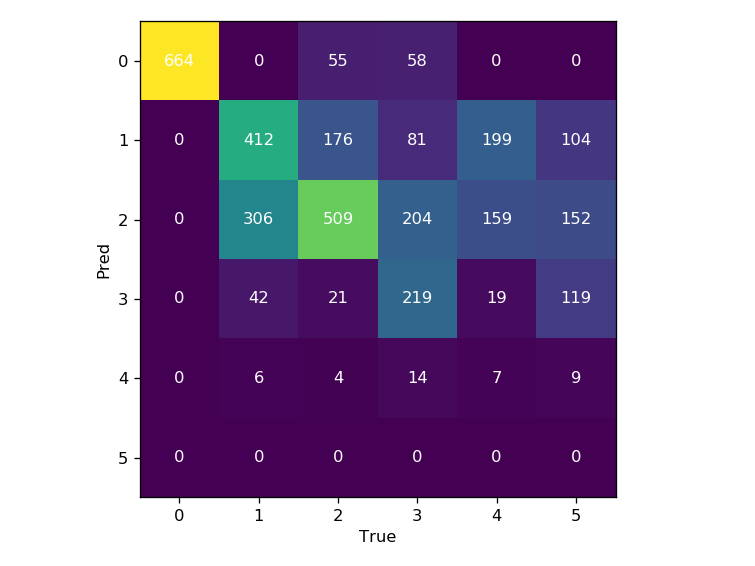

In [22]:
from src.experiment import confusion_matrix
%matplotlib notebook

confusion_matrix(**TEST_PARAMS, test_idx=test_idx, testY=testY)

In [23]:
print('[EVALUATE TRAIN DATA]')
test(**TEST_PARAMS, test_idx=train_idx, testY=trainY)
print('\n[EVALUATE LABELED DATA]')
test(**TEST_PARAMS, test_idx=train_idx[MASK], testY=trainY[MASK])
print('\n[EVALUATE UNLABELED DATA]')
test(**TEST_PARAMS, test_idx=train_idx[~MASK], testY=trainY[~MASK])

[EVALUATE TRAIN DATA]
Test Result of model <ProjectModel1>:best
  [Loss]	1.39447
  [Accuracy]	51.16%

[EVALUATE LABELED DATA]
Test Result of model <ProjectModel1>:best
  [Loss]	0.87852
  [Accuracy]	71.01%

[EVALUATE UNLABELED DATA]
Test Result of model <ProjectModel1>:best
  [Loss]	1.39704
  [Accuracy]	51.06%


In [24]:
from src.utils.plot_utils import *
from src.experiment import get_latents
from sklearn.manifold import TSNE

In [25]:
## get latent vectors and prediction
## z : latent vectors
## preds : predictions
z, preds = get_latents(**TEST_PARAMS, test_idx=test_idx, testY=testY)

## convert z/preds from torch.Tensor to numpy.array
z = z.cpu().numpy()
preds = preds.cpu().numpy()

print(z.shape, preds.shape)

(3539, 32) (3539,)


In [26]:
## reduce feature dimension to 2 with tSNE (for visualization)
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

(3539, 2)


<IPython.core.display.Javascript object>


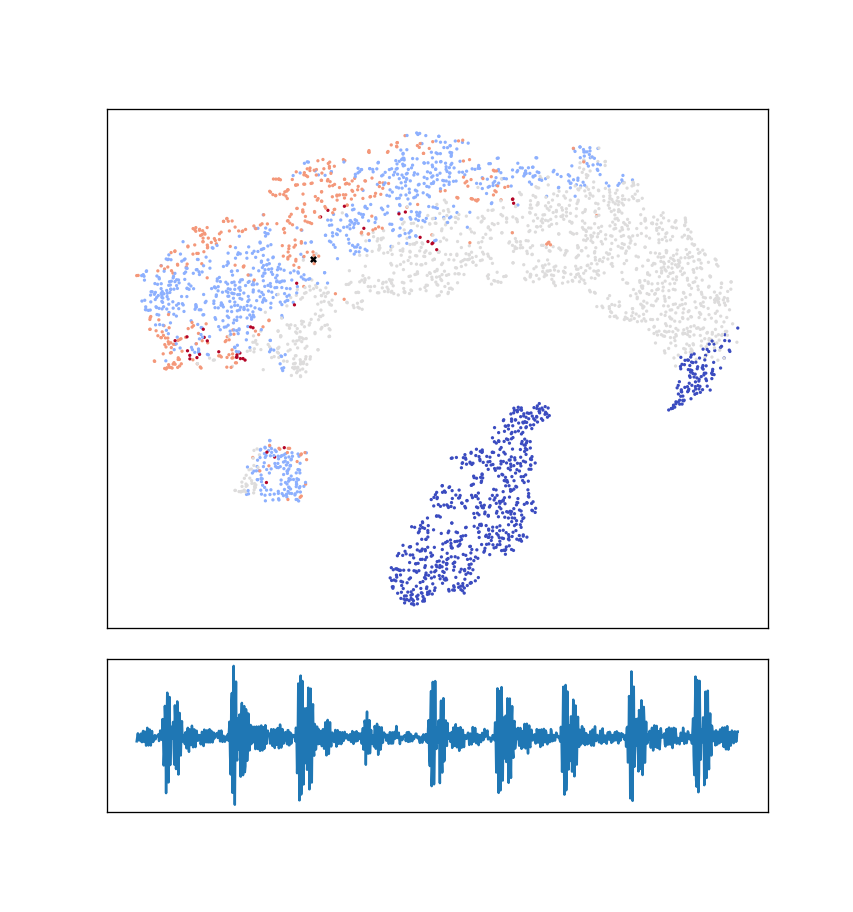

In [27]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

- **Unlabeled 데이터를 어떻게 활용했나요?**
- **모델 구조를 어떻게 수정했나요?**
- **결과는 어떤가요?**
- **왜 이런 결과가 나왔을까요?**